https://github.com/ilguyi/generative.models.tensorflow.v2/blob/master/gans/bigan.ipynb

## Setup

In [0]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy
keras.backend.clear_session()
tf.__version__

'2.2.0-rc4'

## BiGAN


In [0]:
class BiGAN(keras.Model):
  def __init__(self, discriminator, generator, encoder, latent_dim):
    super(BiGAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
    self.encoder = encoder

  def compile(self, d_optimizer, g_optimizer):
    super(BiGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer # this will train encoder too

  def generate(self, z, training=True): 
    return self.generator(z, training)

  def discriminate(self, imgs, encs, training=True):
    return self.discriminator(imgs, encs, training)

  def encode(self, imgs, training=True):
    return self.encoder(imgs, training)

  @tf.function
  def train_step(self, real_images):
    #Loss function

    # Sample random points in the latent space
    batch_size = tf.shape(real_images)[0]

    #Train discriminator
    random_latent_vectors = tf.random.uniform(shape=(batch_size, 1, 1, self.latent_dim), minval=0.0, maxval=0.99)

    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
      # Decode them to fake images
      generated_images = self.generate(random_latent_vectors)

      # Extract features
      encodeds = self.encode(real_images)

      # Get the outputs for real and fake images and latents
      disc_real = self.discriminate(real_images, encodeds)
      disc_fake = self.discriminate(generated_images, random_latent_vectors)

      # Get the discriminator loss going
      disc_loss = tf.reduce_mean(binary_crossentropy(y_true=tf.ones_like(disc_real), y_pred=disc_real, from_logits=True)) + tf.reduce_mean(binary_crossentropy(y_true=tf.zeros_like(disc_fake), y_pred=disc_fake, from_logits=True))

      # Get the gan and encoder loss going
      gen_loss = tf.reduce_mean(binary_crossentropy(y_true=tf.zeros_like(disc_real), y_pred=disc_real, from_logits=True, label_smoothing=1)) + tf.reduce_mean(binary_crossentropy(y_true=tf.ones_like(disc_fake), y_pred=disc_fake, from_logits=True, label_smoothing=1))

    d_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))

    g_grads = gen_tape.gradient(gen_loss, self.generator.trainable_weights + self.encoder.trainable_weights)
    self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights + self.encoder.trainable_weights))

    return {'d_loss': disc_loss, 'g_loss': gen_loss}

In [0]:
TRAIN_BUF=60000
BATCH_SIZE=32
TEST_BUF=10000
DIMS = (28,28,1)
latent_dim = 64
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [0]:
# Create the encoder
def encoder_model():
  inp = keras.Input(shape=DIMS, name = "enc_input")
  netw = layers.Conv2D(64, (4, 4), strides=(2, 2),
                padding='same')(inp)
  netw = layers.LeakyReLU(alpha=0.2)(netw)

  netw = layers.Conv2D(128, (4, 4), strides=(2, 2),
                padding='same', use_bias=False)(netw)
  netw = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(netw)
  netw = layers.LeakyReLU(alpha=0.2)(netw)

  #valid because 28->14->7->3->1
  netw = layers.Conv2D(256, (3, 3), strides=(2, 2),
                padding='valid', use_bias=False)(netw)
  netw = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(netw)
  netw = layers.LeakyReLU(alpha=0.2)(netw)

  z = layers.Conv2D(latent_dim, (3, 3), strides=(1, 1),
                padding='valid')(netw)

  model = tf.keras.Model(inputs=inp, outputs=z)
  return model

encoder = encoder_model()


# Create the discriminator
class discriminator_model(tf.keras.Model):
  def __init__(self):
    super(discriminator_model, self).__init__()
    self.fc0 = layers.Dense(28 * 28 * 2, use_bias=False)
    self.bn0 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    self.lr0 = layers.LeakyReLU(0.2)

    self.conv1 = layers.Conv2D(32, (4,4), padding='same', strides=(2, 2))
    self.lr1 = layers.LeakyReLU(0.2)

    self.conv2 = layers.Conv2D(64, (4,4), padding='same', strides=(2, 2), use_bias=False)
    self.bn1 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    self.lr2 = layers.LeakyReLU(0.2)

    self.conv3 = layers.Conv2D(128, (3,3), strides=(2, 2), padding='valid', use_bias=False)
    self.bn2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    self.lr3 = layers.LeakyReLU(0.2)

    self.conv4 = layers.Conv2D(1, (3,3), strides=(1, 1), padding='valid')

  def call(self, images, latent, training=True):
    latent = tf.squeeze(latent, axis=[1, 2])
    fc = self.fc0(latent)
    fc = self.bn0(fc, training = training)
    fc = self.lr0(fc)
    fc = tf.reshape(fc, [-1, 28, 28, 2])

    inps = tf.concat([images, fc], axis=3)        
    Conv1 = self.conv1(inps)                           
    Conv1 = self.lr1(Conv1)

    Conv2 = self.conv2(Conv1)                             
    Conv2 = self.bn1(Conv2, training = training)
    Conv2 = self.lr2(Conv2)

    Conv3 = self.conv3(Conv2)                             
    Conv3 = self.bn2(Conv3, training = training)
    Conv3 = self.lr3(Conv3) 

    disc_logits = self.conv4(Conv3)                            
    
    return disc_logits

discriminator = discriminator_model()

# Create the generator
def generator_model():
  inp = keras.Input(shape=(1, 1, latent_dim), name="gen_input")

  netw = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='valid', use_bias=False)(inp)
  netw = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(netw)
  netw = layers.ReLU()(netw)

  netw = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='valid', use_bias=False)(netw)
  netw = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(netw)
  netw = layers.ReLU()(netw)

  netw = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(netw)
  netw = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(netw)
  netw = layers.ReLU()(netw)
  
  netw = layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', activation='sigmoid')(netw)
  model = tf.keras.Model(inputs=inp, outputs=netw)
  return model

generator = generator_model()

In [0]:
# Add noise to the real images
@tf.function
def add_noise(image):
  noise = tf.random.normal(shape = (tf.shape(image)), stddev=0.01)
  return image + noise

In [0]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = np.reshape(train_images,(-1, 28, 28, 1)).astype(
    "float32"
) / 255.0
test_images = np.reshape(test_images,(-1, 28, 28, 1)).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
    .map(add_noise)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
    .map(add_noise)
)

In [0]:
gen_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)
disc_optimizer = keras.optimizers.Adam(0.0001, beta_1=0.5)

# model
model = BiGAN(
    generator = generator,
    discriminator = discriminator,
    encoder = encoder,
    latent_dim = latent_dim,
)

model.compile(
    d_optimizer=disc_optimizer,
    g_optimizer=gen_optimizer,
)

In [0]:
hist = model.fit(train_dataset, epochs=15)

Epoch 1/15
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.7581 - g_loss: 1.8206
Epoch 2/15
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6919 - g_loss: 1.8964
Epoch 3/15
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6990 - g_loss: 1.8971
Epoch 4/15
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6716 - g_loss: 2.0077
Epoch 5/15
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.8260 - g_loss: 1.8470
Epoch 6/15
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.8039 - g_loss: 1.8760
Epoch 7/15
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.7271 - g_loss: 2.0100
Epoch 8/15
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.7479 - g_loss: 1.9897
Epoch 9/15
1875/1875 [==============================] - 23s 13ms/step - d_loss: 0.5262 - g_loss: 2.4132
Epoch 10/15
1875/1875 [==============================] - 24s 13m

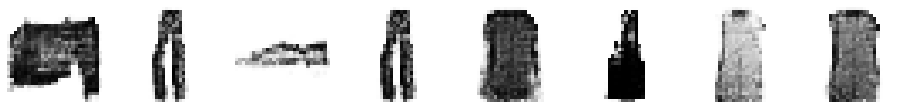

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.predict(tf.random.uniform(shape=(BATCH_SIZE, 1, 1, latent_dim), minval=0.0, maxval=0.99))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

plot_reconstruction(generator)

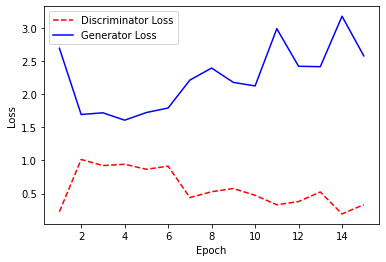

In [0]:
# Get training and test loss histories
g_loss = hist.history['g_loss']
d_loss = hist.history['d_loss']
# Create count of the number of epochs
epoch_count = range(1, len(d_loss) + 1)
# Visualize loss history
plt.plot(epoch_count, d_loss, 'r--')
plt.plot(epoch_count, g_loss, 'b-')

plt.legend(['Discriminator Loss', 'Generator Loss',])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();